In [ ]:
# Clonar el repositorio
!git clone https://github.com/bijoycp/DeepStream-YOLOv8-Jetson-Nano.git

# Cambiar al directorio del proyecto
%cd DeepStream-YOLOv8-Jetson-Nano


Cloning into 'DeepStream-YOLOv8-Jetson-Nano'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 192 (delta 105), reused 174 (delta 87), pack-reused 0 (from 0)
Receiving objects: 100% (192/192), 1004.15 KiB | 11.68 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano


In [ ]:
# Listar los archivos en el directorio
!ls


config_infer_primary_ppyoloe_onnx.txt	    config_infer_primary_yoloV8_onnx.txt
config_infer_primary_ppyoloe_plus_onnx.txt  config_infer_primary_yoloV8.txt
config_infer_primary_ppyoloe_plus.txt	    config_infer_primary_yolox_legacy_onnx.txt
config_infer_primary_ppyoloe.txt	    config_infer_primary_yolox_legacy.txt
config_infer_primary.txt		    config_infer_primary_yolox_onnx.txt
config_infer_primary_yolo_nas_onnx.txt	    config_infer_primary_yolox.txt
config_infer_primary_yolor.txt		    deepstream_app_config.txt
config_infer_primary_yoloV2.txt		    docker
config_infer_primary_yoloV5_onnx.txt	    docs
config_infer_primary_yoloV5.txt		    download_models.sh
config_infer_primary_yoloV6_onnx.txt	    labels.txt
config_infer_primary_yoloV6.txt		    nvdsinfer_custom_impl_Yolo
config_infer_primary_yoloV7_onnx.txt	    README.md
config_infer_primary_yoloV7.txt		    utils


In [ ]:
# Listar todos los archivos Python en el directorio del proyecto
!find . -name "*.py"


./utils/gen_wts_yoloV7.py
./utils/gen_wts_yoloV8.py
./utils/gen_wts_ppyoloe.py
./utils/gen_wts_yolox.py
./utils/gen_wts_yoloV5.py
./utils/gen_wts_yolor.py
./utils/gen_wts_yoloV6.py


In [ ]:
# Ver el contenido de gen_wts_yoloV8.py
!cat utils/gen_wts_yoloV8.py



import argparse
import os
import struct
import torch
from ultralytics.yolo.utils.torch_utils import select_device
from ultralytics.yolo.utils.tal import make_anchors


class Layers(object):
    def __init__(self, n, size, fw, fc):
        self.blocks = [0 for _ in range(n)]
        self.current = -1

        self.width = size[0] if len(size) == 1 else size[1]
        self.height = size[0]

        self.fw = fw
        self.fc = fc
        self.wc = 0

        self.net()

    def Conv(self, child):
        self.current = child.i
        self.fc.write('\n# Conv\n')

        self.convolutional(child)

    def C2f(self, child):
        self.current = child.i
        self.fc.write('\n# C2f\n')

        self.convolutional(child.cv1)
        self.c2f(child.m)
        self.convolutional(child.cv2)

    def SPPF(self, child):
        self.current = child.i
        self.fc.write('\n# SPPF\n')

        self.convolutional(child.cv1)
        self.maxpool(child.m)
        self.maxpool(child.m)
     

In [ ]:
# Crea el archivo generate_call_graph.py
%%writefile generate_call_graph.py

from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput
import utils.gen_wts_yoloV8 as script

graphviz = GraphvizOutput()
graphviz.output_file = 'call_graph.png'

with PyCallGraph(output=graphviz):
    # Simulamos la ejecución del script
    script.pt_file = 'path/to/your/weights.pt'  # Cambia esto a la ruta real de tu archivo .pt
    script.inference_size = [640]
    script.model_name = 'yolov8'
    script.wts_file = script.model_name + '.wts'
    script.cfg_file = script.model_name + '.cfg'
    script.device = select_device('cpu')
    script.model = torch.load(script.pt_file, map_location=script.device)['model'].float()
    script.model.to(script.device).eval()

    if script.model.names and script.model.nc:
        with open("labels.txt", 'w') as fw:
            for i in range(script.model.nc):
                fw.write(script.model.names[i] + '\n')

    with open(script.wts_file, 'w') as fw, open(script.cfg_file, 'w') as fc:
        layers = script.Layers(len(script.model.model), script.inference_size, fw, fc)

        for child in script.model.model.children():
            if child._get_name() == 'Conv':
                layers.Conv(child)
            elif child._get_name() == 'C2f':
                layers.C2f(child)
            elif child._get_name() == 'SPPF':
                layers.SPPF(child)
            elif child._get_name() == 'Upsample':
                layers.Upsample(child)
            elif child._get_name() == 'Concat':
                layers.Concat(child)
            elif child._get_name() == 'Detect':
                layers.Detect(child)
                x = []
                for stride in script.model.stride.tolist():
                    x.append(torch.zeros([1, 1, int(layers.height / stride), int(layers.width / stride)], dtype=torch.float32))
                anchor_points, stride_tensor = (x.transpose(0, 1) for x in make_anchors(x, child.stride, 0.5))
                layers.get_anchors(anchor_points.reshape([-1]), stride_tensor.reshape([-1]))
            else:
                raise SystemExit('Model not supported')

    os.system('echo "%d" | cat - %s > temp && mv temp %s' % (layers.wc, script.wts_file, script.wts_file))


Overwriting generate_call_graph.py


In [ ]:
!pip install pycallgraph2 torch ultralytics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 13.5 MB/s eta 0:00:00


Traceback (most recent call last):
  File "/content/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/generate_call_graph.py", line 4, in <module>
    import utils.gen_wts_yoloV8 as script
  File "/content/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/DeepStream-YOLOv8-Jetson-Nano/utils/gen_wts_yoloV8.py", line 5, in <module>
    from ultralytics.yolo.utils.torch_utils import select_device
ModuleNotFoundError: No module named 'ultralytics.yolo'


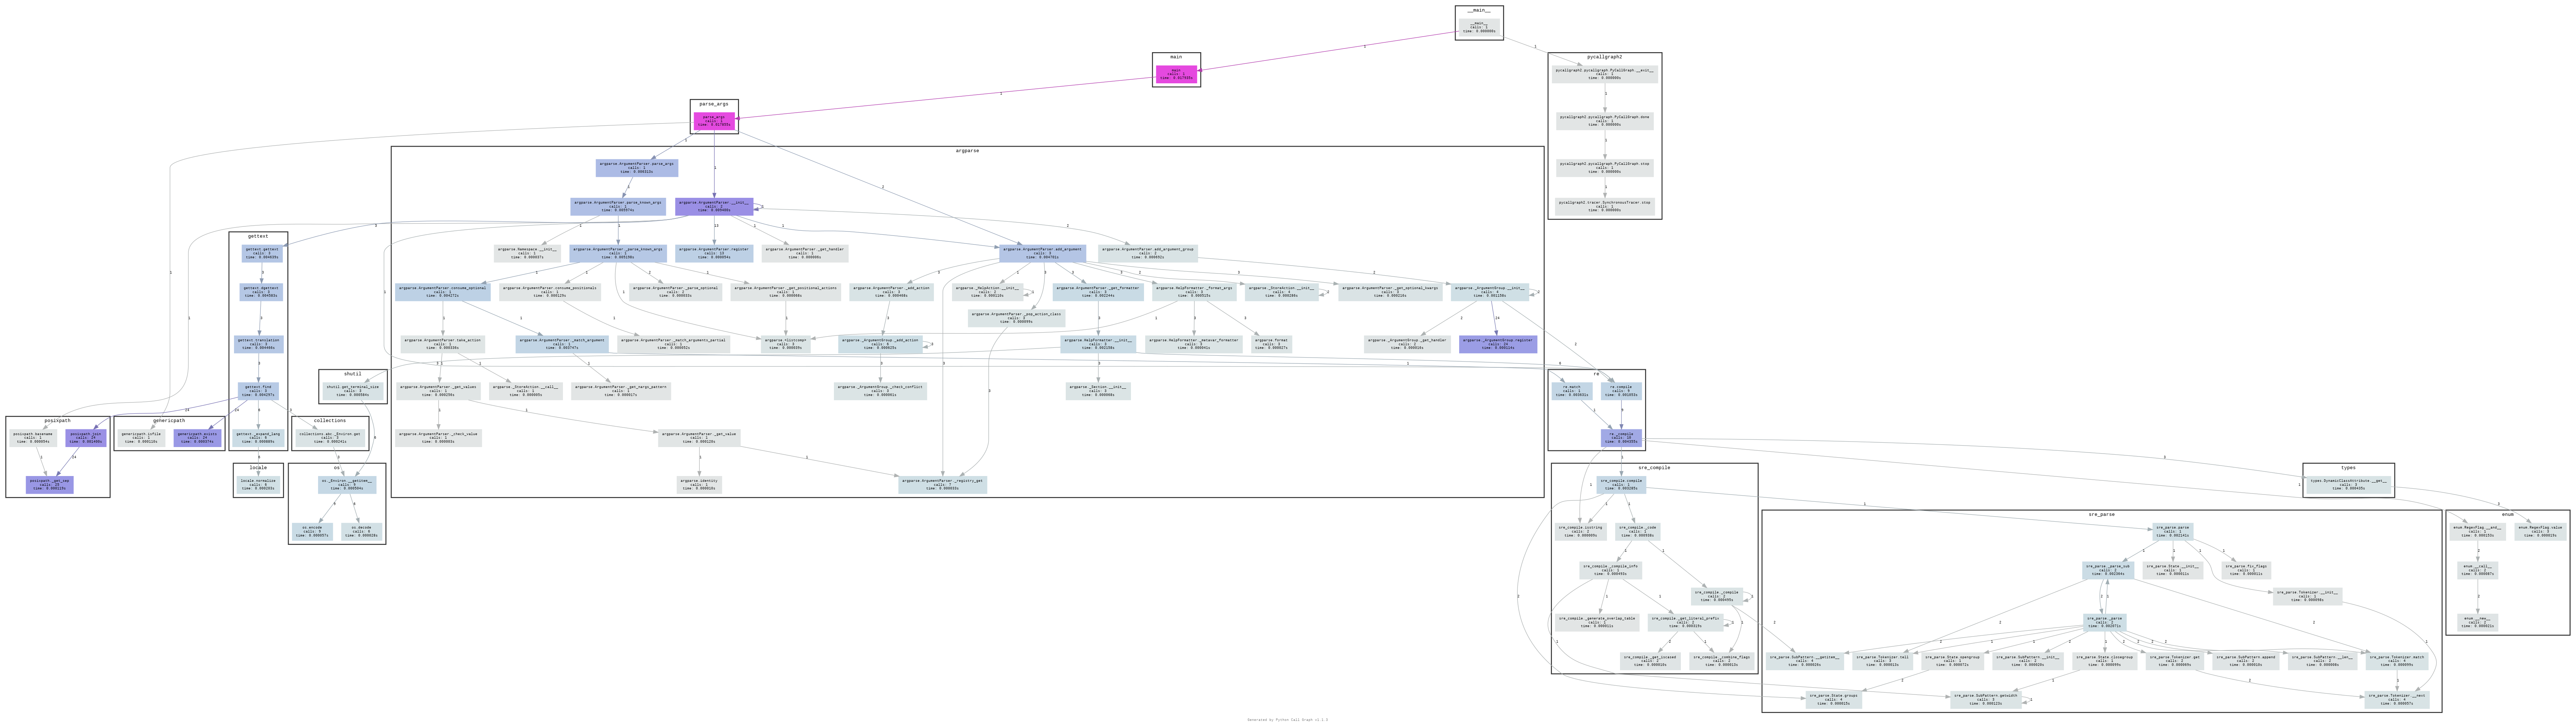

In [ ]:
# Ejecutar el script para generar el call graph
!python generate_call_graph.py

# Mostrar la imagen del call graph
from IPython.display import Image
Image(filename='call_graph.png')
